In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report
print('Libraries imported successfully!')
print(f'PyTorch version: {torch.__version__}')
print(f'Device: {"CUDA" if torch.cuda.is_available() else "CPU"}')


Libraries imported successfully!
PyTorch version: 2.10.0+cpu
Device: CPU


In [ ]:
df = pd.read_csv('data/weatherAUS.csv')

print(f'Dataset Shape: {df.shape}')
df.head()

Dataset Shape: (145460, 23)

First 5 rows:


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


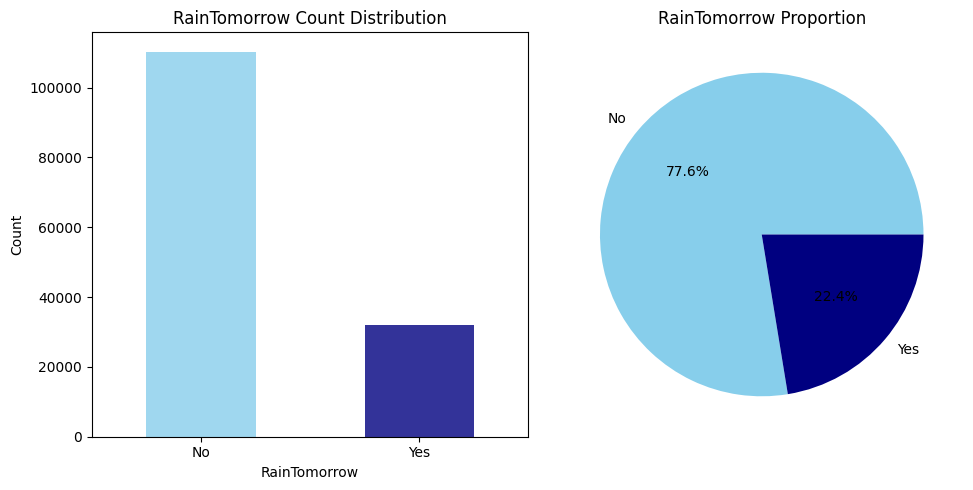

Class Distribution:
RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df['RainTomorrow'].value_counts().plot(kind='bar', color=['skyblue', 'navy'], alpha=0.8)
plt.title('RainTomorrow Count Distribution')
plt.xlabel('RainTomorrow')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df['RainTomorrow'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'navy'])
plt.title('RainTomorrow Proportion')
plt.ylabel('')

plt.tight_layout()
plt.show()

print(f"Class Distribution:\n{df['RainTomorrow'].value_counts()}")

In [ ]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace=True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace=True)


print(f'RainTomorrow unique values: {df["RainTomorrow"].unique()}')

Target variable converted to binary (0/1)
RainTomorrow unique values: [ 0.  1. nan]


Handling Class Imbalance For Rainfall Prediction

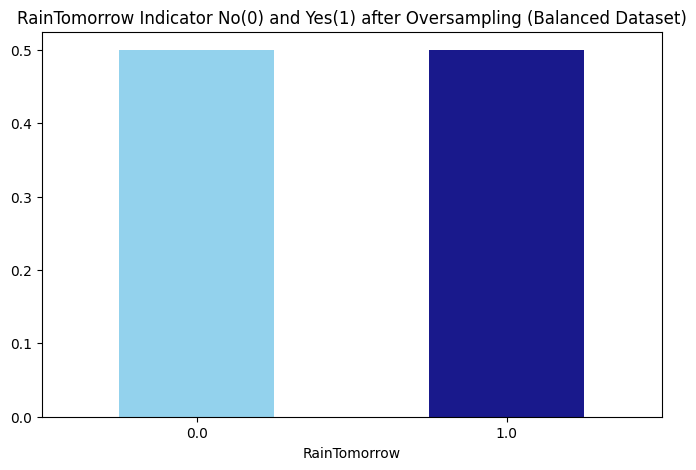

In [20]:
from sklearn.utils import resample

no = df[df.RainTomorrow == 0]
yes = df[df.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

In [21]:
missing_values=df.isnull().sum() # missing values

percent_missing = df.isnull().sum()/df.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing , 
    'data type' : df.dtypes
}
frame=pd.DataFrame(value)
frame

,missing_values,percent_missing %,data type
Date,0,0.000000,object
Location,0,0.000000,object
MinTemp,1485,1.020899,float64
MaxTemp,1261,0.866905,float64
Rainfall,3261,2.241853,float64
Evaporation,62790,43.166506,float64
Sunshine,69835,48.009762,float64
WindGustDir,10326,7.098859,object
WindGustSpeed,10263,7.055548,float64
WindDir9am,10566,7.263853,object


<Axes: >

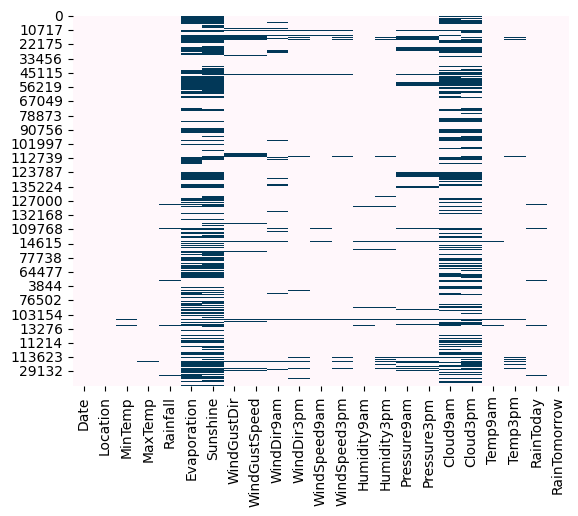

In [22]:
import seaborn as sns
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

In [23]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


In [24]:
oversampled.select_dtypes(include=['object']).columns


Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

### Imputation and Transformation

We will impute the categorical columns with mode, and then we will use the label encoder to convert them to numeric numbers. Once all the columns in the full data frame are converted to numeric columns, we will impute the missing values ​​using the Multiple Imputation by Chained Equations (MICE) package.

Then we will detect outliers using the interquartile range and remove them to get the final working dataset. Finally, we will check the correlation between the different variables, and if we find a pair of highly correlated variables, we will discard one while keeping the other.

In [25]:
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [26]:
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [27]:
import warnings
warnings.filterwarnings("ignore")
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [28]:
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)


Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.120044
Sunshine            5.979485
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.684676
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


In [29]:
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(170669, 23)

In [30]:
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

In [31]:
# Prepare Features and Target

# Drop non-predictive columns
features = modified_data.drop(['RainTomorrow'], axis=1)
target = modified_data['RainTomorrow']

print(f'Features shape: {features.shape}')
print(f'Target shape: {target.shape}')
print(f'\nTarget distribution:\n{target.value_counts()}')

Features shape: (170669, 22)
Target shape: (170669,)

Target distribution:
RainTomorrow
0.0    95650
1.0    75019
Name: count, dtype: int64


In [32]:
# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    features, target, 
    test_size=0.2, 
    random_state=42, 
    stratify=target
)

print(f'Training set: {X_train.shape}')
print(f'Test set: {X_test.shape}')
print(f'\nTraining target distribution:\n{y_train.value_counts()}')
print(f'\nTest target distribution:\n{y_test.value_counts()}')

Training set: (136535, 22)
Test set: (34134, 22)

Training target distribution:
RainTomorrow
0.0    76520
1.0    60015
Name: count, dtype: int64

Test target distribution:
RainTomorrow
0.0    19130
1.0    15004
Name: count, dtype: int64


In [33]:
# Convert to PyTorch Tensors

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

print(f'\nTensor shapes:')
print(f'X_train: {X_train_tensor.shape}')
print(f'y_train: {y_train_tensor.shape}')
print(f'X_test: {X_test_tensor.shape}')
print(f'y_test: {y_test_tensor.shape}')

Using device: cpu

Tensor shapes:
X_train: torch.Size([136535, 22])
y_train: torch.Size([136535, 1])
X_test: torch.Size([34134, 22])
y_test: torch.Size([34134, 1])


In [34]:
# Create DataLoaders

batch_size = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Batch size: {batch_size}')
print(f'Number of training batches: {len(train_loader)}')
print(f'Number of test batches: {len(test_loader)}')

Batch size: 64
Number of training batches: 2134
Number of test batches: 534


In [35]:
# Define Deep Neural Network (DNN) Model

class RainfallDNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], dropout_rate=0.3):
        super(RainfallDNN, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Initialize model
input_size = X_train.shape[1]
dnn_model = RainfallDNN(input_size=input_size).to(device)

print(f'DNN Model Architecture:')
print(dnn_model)
print(f'\nTotal parameters: {sum(p.numel() for p in dnn_model.parameters()):,}')

DNN Model Architecture:
RainfallDNN(
  (network): Sequential(
    (0): Linear(in_features=22, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

Total parameters: 13,761


In [36]:
# Training Configuration for DNN

criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(dnn_model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 50

print(f'Loss Function: Binary Cross Entropy')
print(f'Optimizer: Adam')
print(f'Learning Rate: 0.001')
print(f'Number of Epochs: {num_epochs}')

Loss Function: Binary Cross Entropy
Optimizer: Adam
Learning Rate: 0.001
Number of Epochs: 50


In [37]:
# Train DNN Model

from tqdm import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print('Training DNN Model...')
print('=' * 50)

for epoch in range(num_epochs):
    # Training phase
    dnn_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = dnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        predictions = (outputs >= 0.5).float()
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
    
    # Validation phase
    dnn_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = dnn_model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            predictions = (outputs >= 0.5).float()
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
    
    # Calculate metrics
    avg_train_loss = train_loss / train_total
    avg_val_loss = val_loss / val_total
    train_acc = 100 * train_correct / train_total
    val_acc = 100 * val_correct / val_total
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print('-' * 50)

print('\nTraining completed!')

Training DNN Model...
Epoch [10/50]
  Train Loss: 0.3377 | Train Acc: 85.32%
  Val Loss: 0.3063 | Val Acc: 86.87%
--------------------------------------------------
Epoch [20/50]
  Train Loss: 0.3230 | Train Acc: 86.03%
  Val Loss: 0.2757 | Val Acc: 88.32%
--------------------------------------------------
Epoch [30/50]
  Train Loss: 0.3214 | Train Acc: 86.08%
  Val Loss: 0.2694 | Val Acc: 88.34%
--------------------------------------------------
Epoch [40/50]
  Train Loss: 0.3190 | Train Acc: 86.09%
  Val Loss: 0.2697 | Val Acc: 88.29%
--------------------------------------------------
Epoch [50/50]
  Train Loss: 0.3113 | Train Acc: 86.52%
  Val Loss: 0.2617 | Val Acc: 88.70%
--------------------------------------------------

Training completed!


In [ ]:
# Evaluate DNN Model

dnn_model.eval()
all_predictions = []
all_labels = []
all_probabilities = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = dnn_model(inputs)
        predictions = (outputs >= 0.5).float()
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probabilities.extend(outputs.cpu().numpy())

all_predictions = np.array(all_predictions).flatten()
all_labels = np.array(all_labels).flatten()
all_probabilities = np.array(all_probabilities).flatten()

# Classification Report
print('\nClassification Report:')
print(classification_report(all_labels, all_predictions, target_names=['No Rain', 'Rain']))

DNN Model Performance Metrics:
Accuracy:  0.8870 (88.70%)
Precision: 0.8794
Recall:    0.8611
F1-Score:  0.8702
ROC AUC:   0.9582

Classification Report:
              precision    recall  f1-score   support

     No Rain       0.89      0.91      0.90     19130
        Rain       0.88      0.86      0.87     15004

    accuracy                           0.89     34134
   macro avg       0.89      0.88      0.89     34134
weighted avg       0.89      0.89      0.89     34134



In [ ]:
class RainfallLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super(RainfallLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=1,  # Each feature as a timestep
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Reshape input: (batch_size, features) -> (batch_size, features, 1)
        x = x.unsqueeze(2)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        
        # Take the last output
        x = lstm_out[:, -1, :]
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x

# Initialize LSTM model
lstm_model = RainfallLSTM(input_size=X_train.shape[1]).to(device)

print(f'LSTM Model Architecture:')
print(lstm_model)
print(f'\nTotal parameters: {sum(p.numel() for p in lstm_model.parameters()):,}')

LSTM Model Architecture:
RainfallLSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 52,545


In [ ]:
lstm_criterion = nn.BCELoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001, weight_decay=1e-5)

lstm_num_epochs = 50

LSTM Training Configuration:
Loss Function: Binary Cross Entropy
Optimizer: Adam
Learning Rate: 0.001
Number of Epochs: 50


In [ ]:
from tqdm import tqdm

stm_train_losses = []
lstm_val_losses = []
lstm_train_accuracies = []
lstm_val_accuracies = []

print('Training LSTM Model...')
print('=' * 50)

for epoch in tqdm(range(lstm_num_epochs)):
    # Training phase
    lstm_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        lstm_optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = lstm_criterion(outputs, labels)
        loss.backward()
        lstm_optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        predictions = (outputs >= 0.5).float()
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
    
    # Validation phase
    lstm_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = lstm_model(inputs)
            loss = lstm_criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            predictions = (outputs >= 0.5).float()
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
    
    # Calculate metrics
    avg_train_loss = train_loss/train_total if train_total > 0 else 0
    avg_val_loss = val_loss/val_total if val_total > 0 else 0
    train_acc = 100 * train_correct/train_total if train_total > 0 else 0
    val_acc = 100 * val_correct/val_total if val_total > 0 else 0
    
    lstm_val_losses.append(avg_val_loss)
    lstm_train_accuracies.append(train_acc)
    lstm_val_accuracies.append(val_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{lstm_num_epochs}]')
        print(f'  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print('-' * 50)


In [ ]:
lstm_model.eval()
lstm_predictions = []
lstm_labels = []
lstm_probabilities = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = lstm_model(inputs)
        predictions = (outputs >= 0.5).float()
        
        lstm_predictions.extend(predictions.cpu().numpy())
        lstm_labels.extend(labels.numpy())
        lstm_probabilities.extend(outputs.cpu().numpy())

lstm_predictions = np.array(lstm_predictions).flatten()
lstm_labels = np.array(lstm_labels).flatten()
lstm_probabilities = np.array(lstm_probabilities).flatten()

print(classification_report(lstm_labels, lstm_predictions, target_names=['No Rain', 'Rain']))